In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
!pip -q install ultralytics
!pip -q install gdown
import torch
from ultralytics import YOLO
import gdown
import sklearn
from sklearn import model_selection
import pathlib
import shutil
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 10.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
import zipfile

zip_ref= zipfile.ZipFile("/content/drive/MyDrive/Project/dataset_updated.zip", "r")

zip_ref.extractall()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Project/dataset_updated.zip'

In [ ]:
!gdown -q 1i_tiapXLZ3csB6qHmq-J6M3K2Y_b8cxT
!unzip -q /content/dataset.zip

In [ ]:
shutil.move("/content/dataset/test_dark", "/content/test_dark")
shutil.move("/content/dataset/train_dark", "/content/train_dark")
shutil.move("/content/dataset/data.yaml", "/content/data.yaml")

'/content/data.yaml'

In [ ]:
# from google.colab import files
# files.upload()

{}

##**1.2. View samples**

In [ ]:
master_class= ["aegypti", "albopictus", "anopheles", "culex", "culiseta","japonicus/koreicus"]

idx2class={}
for key, value in enumerate(master_class):
  idx2class[key]= value

In [ ]:
def view_samples(im_dir= "/content/dataset_updated/train_dark/images"):

    im_names= os.listdir(im_dir)
    im_names= np.random.choice(im_names, 9)
    fig, axs= plt.subplots(3, 3, figsize= (15, 15))
    bounded_ims= []

    for im_name in im_names:
        im_path= im_dir+ f"/{im_name}"
        label_path= "/content/dataset_updated/train_dark/labels/"+ im_name.split(".")[0]+ ".txt"
        im= cv2.imread(im_path, 1)
        H,W,C = im.shape
        with open(label_path, "r") as f:
            content= f.readlines()
        f.close()
        for line in content:
            idx, xc, yc, w, h= [float(i) for i in line.split()]
            xc, yc, w, h= xc*W, yc*H, w*W, h*H
            im= cv2.rectangle(im, (int(xc-w/2), int(yc-h/2)), (int(xc+w/2), int(yc+h/2)), (0, 255, 0), 2)
            im= cv2.putText(im, f'{int(idx)}', (int(xc-w/2), int(yc-h/2)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        bounded_ims.append(im)

    count= 0
    for r in range(3):
        for c in range(3):
            im= cv2.cvtColor(bounded_ims[count], cv2.COLOR_BGR2RGB)
            axs[r][c].imshow(im)
            axs[r][c].axis("off")
            count+=1
    plt.show()

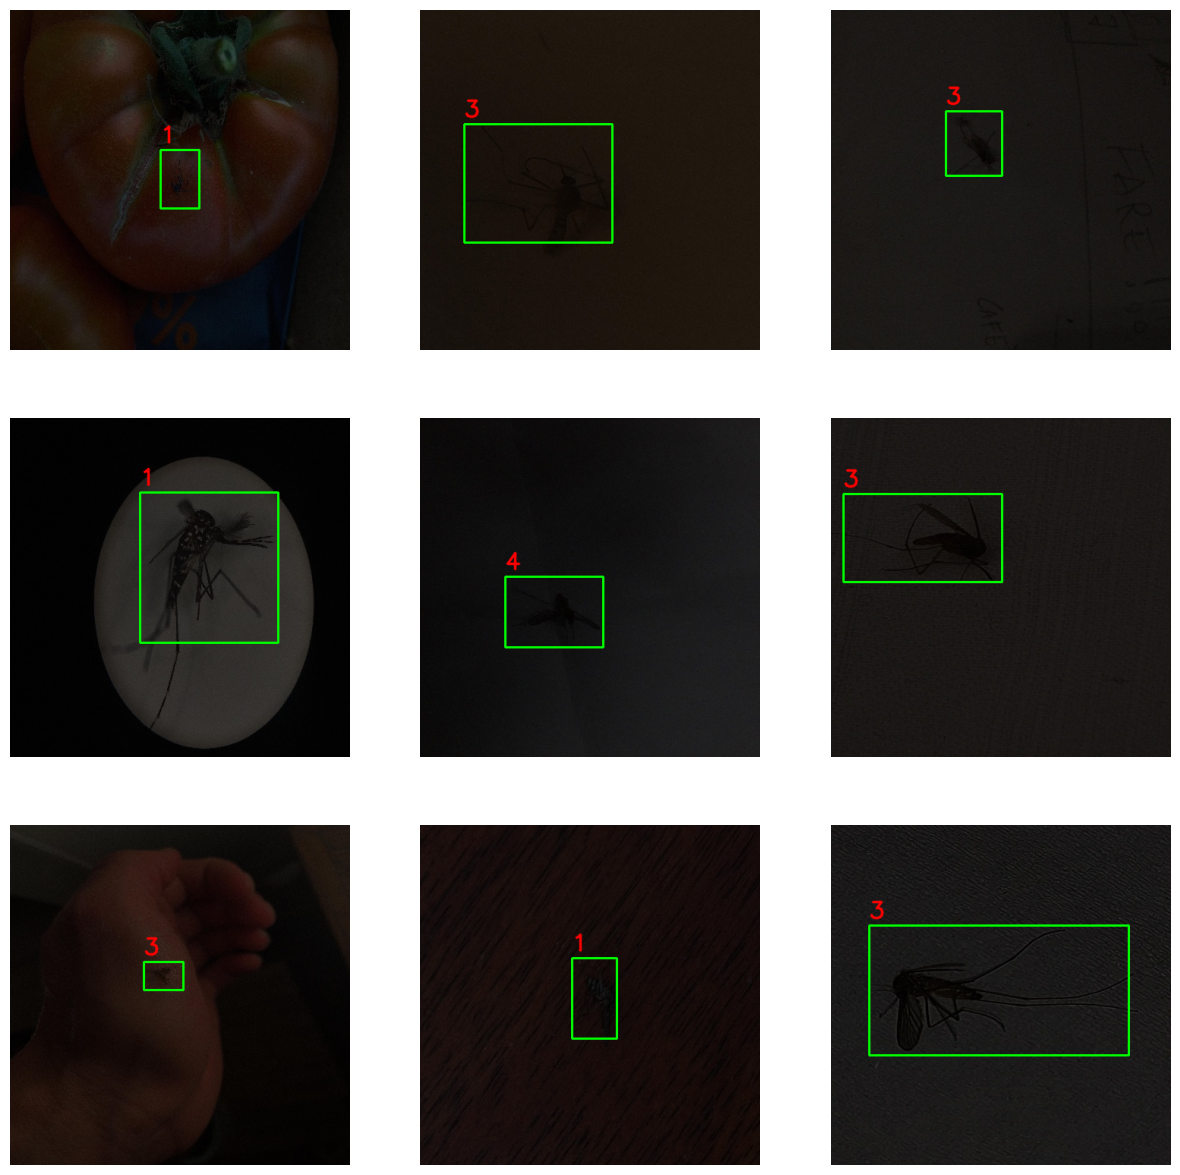

In [ ]:
view_samples()

In [ ]:
def find_percentile(im_dir, p= 0.75):
  h, w= [], []
  if glob.glob(im_dir+"/*.jpg") == []:
    f_paths= glob.glob(im_dir+"/*.jpeg")
    for path in f_paths:
      im= cv2.imread(path, 0)
      h.append(im.shape[0])
      w.append(im.shape[1])

  return np.percentile(np.array(h), p), np.percentile(np.array(w), p)

In [ ]:
h1, w1= find_percentile("/content/train_dark/images") #(106, 152)
h2, w2= find_percentile("/content/test_dark/images") #(157, 189)

h, w= min([h1, h2]), min([w1, w2])
h, w

(453.4, 451.2425)

In [ ]:
def closest_mult(x, n =32):
  print(x)
  q= int(x/n)
  return n*q

In [ ]:
h, w= closest_mult(h), closest_mult(w)

453.4
451.2425


In [ ]:
def resize(im_dir, h , w):
  if h <= 0 or w <= 0:
    raise ValueError("h and w must be greater than 0.")
  f_paths= glob.glob(im_dir+"/*.jpeg")
  for path in f_paths:
    im= cv2.imread(path, 1)
    cv2.imwrite(path, cv2.resize(im, (h, w)))
  print("Done!!")

In [ ]:
resize("/content/train_dark/images", h, w)
resize("/content/test_dark/images", h, w)

Done!!
Done!!


In [ ]:
print(h,w)

448 448


In [ ]:
def train_val_split(dir= "/content/train_dark/images"):
  train_paths, val_paths= model_selection.train_test_split(glob.glob(dir+ "/*.jpeg"), train_size= 0.75, test_size= 0.25)
  pathlib.Path(f"/content/val_dark/images").mkdir(parents= True, exist_ok= True)
  pathlib.Path(f"/content/val_dark/labels").mkdir(parents= True, exist_ok= True)
  for path in val_paths:
    im_p_src= path
    txt_p_src= im_p_src[:-4]+"txt"
    txt_p_src= txt_p_src.split("/")
    txt_p_src[3]= "labels"
    txt_p_src= "/".join(txt_p_src)

    im_p_dst= im_p_src.split("/")
    im_p_dst[2]= "val_dark"
    im_p_dst= "/".join(im_p_dst)
    txt_p_dst= im_p_dst[:-4]+"txt"
    txt_p_dst= txt_p_dst.split("/")
    txt_p_dst[3]= "labels"
    txt_p_dst= "/".join(txt_p_dst)

    shutil.move(im_p_src, im_p_dst)
    shutil.move(txt_p_src, txt_p_dst)
  print("Done!!")

In [ ]:
train_val_split()

Done!!


In [ ]:
len(glob.glob("/content/val_dark/labels/*txt")), len(glob.glob("/content/val_dark/images/*jpeg"))

(1875, 1875)

In [ ]:
len(glob.glob("/content/train_dark/labels/*txt")), len(glob.glob("/content/train_dark/images/*jpeg"))

(5625, 5625)

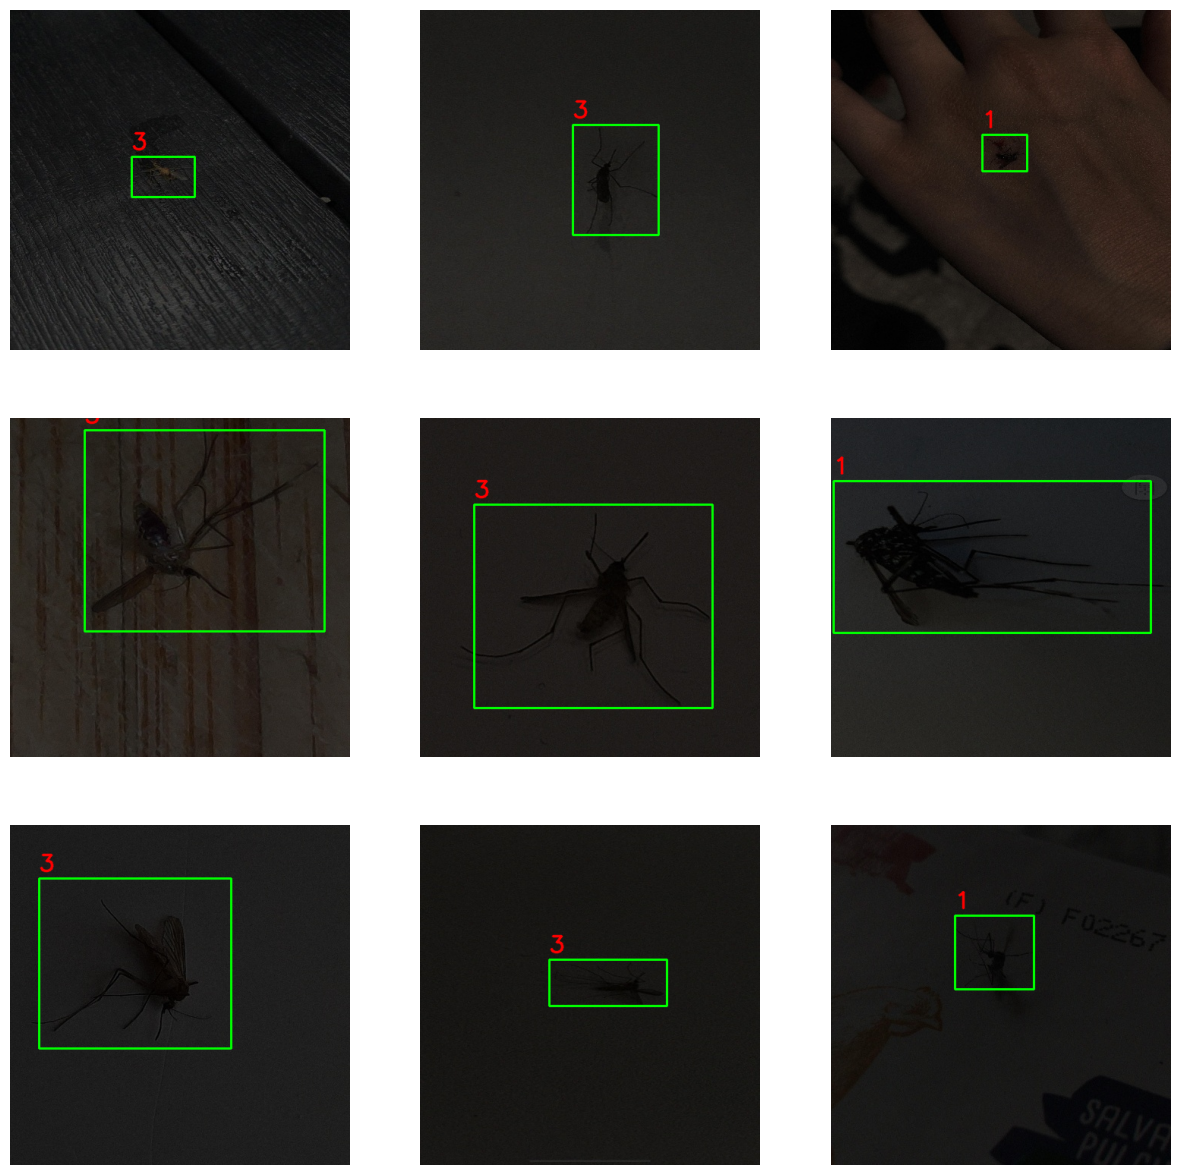

In [ ]:
view_samples()

In [ ]:
# !zip -r train_dark.zip /content/train_dark
# !zip -r vali_dark.zip /content/val_dark
# !zip -r testi_dark.zip /content/test_dark

##**1.3. YOLO v8 model**

In [ ]:
import locale
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

UTF-8


In [ ]:
!gdown -q 1BCLRPwk3lyaZsr095SFYgO9cpv93NsrV #last_run3

In [ ]:
# !gdown -q 1-Ew6JKafPFuAv49pTorewpM42yZbReWQ #enhanced_dataset
# !unzip -q /content/dataset_enhanced.zip

In [ ]:
# !gdown -q 1V1u9TnRPHNTog-eI2VD-eZ7Slhjc8cFg #enhanced_dataset v2
# !unzip -q /content/enhanced_dataset_v2.zip

In [ ]:
!gdown -q 1dU3S_rBmHHs-VvrUrSAysRxli0D6GwKc
!unzip -q /content/dataset_enhanced_3.zip

In [ ]:
train_txt= glob.glob("/content/dataset_enhanced/train_enhanced/labels/*.txt")
val_txt= glob.glob("/content/dataset_enhanced/val_enhanced/labels/*.txt")
txts= []
txts.extend(train_txt)
txts.extend(val_txt)
len(train_txt), len(val_txt)

(7247, 2418)

In [ ]:
content= []
for txt in txts:
  f= open(txt, "r")
  content.append(f.readlines()[0].split())
  f.close()

In [ ]:
df= pd.DataFrame(content, columns= ["id", "xc", "yc", "w", "h"])

In [ ]:
df["id"].value_counts()

id
1    3334
3    3312
4    1538
5    1021
0     320
2     140
Name: count, dtype: int64

In [ ]:
from google.colab import files
response= input("Do you have a pretrained model(y/n):")

if response== "y":
  # print("upload the pretrained model:")
  # files.upload()
  num= int(input("run_"))

  PATH= f"/content/last.pt"
  # PATH= f"/content/drive/MyDrive/Project/yolov8n_checkpoints/run_{num}/last.pt"

else:
  PATH= "yolov8x.pt"
  num= 0

Do you have a pretrained model(y/n):y
run_3


In [ ]:
model= YOLO(PATH)

if response== "y":
  train_results= model.train(data= "/content/dataset_enhanced/data.yaml", epochs= 25, imgsz= (448, 448), resume= False, project= "low_light_object_detection")

else:
  train_results= model.train(data= "/content/dataset_enhanced/data.yaml", epochs= 25, imgsz= (448, 448), resume= False, project= "low_light_object_detection")

Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/last.pt, data=/content/dataset_enhanced/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=(448, 448), save=True, save_period=-1, cache=False, device=None, workers=8, project=low_light_object_detection, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

100%|██████████| 755k/755k [00:00<00:00, 137MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 253MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=448'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/dataset_enhanced/train_enhanced/labels... 7247 images, 0 backgrounds, 1 corrupt: 100%|██████████| 7247/7247 [00:03<00:00, 1976.55it/s]

train: WARNING ⚠️ /content/dataset_enhanced/train_enhanced/images/120b30b0-c7db-4f0a-bead-a30424a65453.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0068]


train: New cache created: /content/dataset_enhanced/train_enhanced/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset_enhanced/val_enhanced/labels... 2418 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2418/2418 [00:01<00:00, 1340.03it/s]

val: New cache created: /content/dataset_enhanced/val_enhanced/labels.cache


Plotting labels to low_light_object_detection/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 448 train, 448 val
Using 2 dataloader workers
Logging results to low_light_object_detection/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      1.33G      1.275      1.459      1.301         29        448: 100%|██████████| 453/453 [01:51<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:18<00:00,  4.07it/s]

                   all       2418       2418      0.655      0.498      0.433      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      1.15G      1.322      1.478      1.338         26        448: 100%|██████████| 453/453 [01:45<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.59it/s]

                   all       2418       2418      0.705      0.511      0.446      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      1.15G      1.361      1.503      1.359         32        448: 100%|██████████| 453/453 [01:40<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.51it/s]


                   all       2418       2418      0.548       0.48      0.458      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      1.15G      1.362      1.499      1.355         21        448: 100%|██████████| 453/453 [01:40<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.51it/s]

                   all       2418       2418      0.571      0.554      0.508      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      1.15G      1.348      1.456      1.348         25        448: 100%|██████████| 453/453 [01:40<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.52it/s]


                   all       2418       2418      0.596      0.557      0.546       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      1.15G      1.334      1.434      1.342         39        448: 100%|██████████| 453/453 [01:42<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.51it/s]


                   all       2418       2418      0.618      0.557      0.535      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      1.15G       1.32      1.428      1.333         28        448: 100%|██████████| 453/453 [01:40<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:18<00:00,  4.21it/s]


                   all       2418       2418      0.661      0.549      0.542      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      1.15G      1.307      1.391      1.322         26        448: 100%|██████████| 453/453 [01:42<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:18<00:00,  4.18it/s]


                   all       2418       2418      0.656      0.548      0.544      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      1.15G      1.313      1.384      1.325         34        448: 100%|██████████| 453/453 [01:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.24it/s]

                   all       2418       2418      0.628      0.565      0.541      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      1.15G      1.293       1.35      1.316         28        448: 100%|██████████| 453/453 [01:39<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.30it/s]

                   all       2418       2418      0.661       0.52      0.538      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      1.15G      1.282      1.321      1.305         22        448: 100%|██████████| 453/453 [01:39<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.33it/s]

                   all       2418       2418       0.75      0.529      0.568      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      1.15G      1.272      1.322        1.3         23        448: 100%|██████████| 453/453 [01:47<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.67it/s]

                   all       2418       2418      0.625      0.553      0.541      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      1.15G      1.265      1.292      1.295         27        448: 100%|██████████| 453/453 [01:38<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.68it/s]

                   all       2418       2418      0.677       0.48      0.518      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      1.15G      1.251      1.276       1.29         23        448: 100%|██████████| 453/453 [01:38<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.61it/s]

                   all       2418       2418      0.654      0.567      0.543      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      1.15G      1.244      1.265      1.279         30        448: 100%|██████████| 453/453 [01:44<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.40it/s]

                   all       2418       2418      0.715      0.557      0.597      0.425


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      1.29G      1.088      1.004      1.185         14        448: 100%|██████████| 453/453 [01:35<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.46it/s]

                   all       2418       2418      0.706      0.576      0.595      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      1.15G      1.076     0.9688      1.177         14        448: 100%|██████████| 453/453 [01:38<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.53it/s]

                   all       2418       2418       0.71      0.587      0.601      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      1.15G      1.061     0.9433      1.167         14        448: 100%|██████████| 453/453 [01:33<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.32it/s]

                   all       2418       2418      0.689      0.598      0.605      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      1.15G      1.042     0.9206      1.156         14        448: 100%|██████████| 453/453 [01:38<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.47it/s]

                   all       2418       2418      0.683      0.605      0.611      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      1.15G       1.03     0.9032       1.15         14        448: 100%|██████████| 453/453 [01:33<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:16<00:00,  4.58it/s]

                   all       2418       2418      0.698       0.59      0.604      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      1.15G      1.011     0.8822      1.136         14        448: 100%|██████████| 453/453 [01:35<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:18<00:00,  4.04it/s]

                   all       2418       2418      0.685      0.605       0.61      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      1.15G      1.002     0.8648      1.132         14        448: 100%|██████████| 453/453 [01:34<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.40it/s]

                   all       2418       2418       0.69      0.595       0.62      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      1.15G       0.99     0.8389      1.123         14        448: 100%|██████████| 453/453 [01:34<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:19<00:00,  3.95it/s]

                   all       2418       2418      0.723      0.568      0.618      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      1.15G     0.9756     0.8266      1.113         14        448: 100%|██████████| 453/453 [01:36<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:18<00:00,  4.10it/s]

                   all       2418       2418      0.686      0.622      0.619      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      1.15G     0.9691     0.8085      1.111         14        448: 100%|██████████| 453/453 [01:39<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:17<00:00,  4.36it/s]


                   all       2418       2418      0.743      0.556      0.622      0.457

25 epochs completed in 0.820 hours.
Optimizer stripped from low_light_object_detection/train/weights/last.pt, 6.2MB
Optimizer stripped from low_light_object_detection/train/weights/best.pt, 6.2MB

Validating low_light_object_detection/train/weights/best.pt...
Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:21<00:00,  3.53it/s]


                   all       2418       2418      0.743      0.556      0.622      0.457
               aegypti       2418         80      0.387      0.118      0.219      0.147
            albopictus       2418        834      0.895      0.766      0.904      0.631
             anopheles       2418         35          1          0     0.0762     0.0582
                 culex       2418        828      0.874      0.815      0.906      0.632
              culiseta       2418        385      0.686      0.896      0.878      0.699
    japonicus/koreicus       2418        256      0.619      0.742      0.748      0.575
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to low_light_object_detection/train


#**1.4. Saving model**

In [ ]:
import shutil
import pathlib

pathlib.Path(f"/content/drive/MyDrive/Project/yolov8n_checkpoints/run_{num+1}").mkdir(parents= True, exist_ok= True)
shutil.copy2("/content/low_light_object_detection/train2/weights/last.pt", f"/content/drive/MyDrive/Project/yolov8n_checkpoints/run_{num+1}")

'/content/drive/MyDrive/Project/yolov8n_checkpoints/run_3/last.pt'

In [ ]:
shutil.copy2("/content/low_light_object_detection/train2/weights/best.pt", f"/content/drive/MyDrive/Project/yolov8n_checkpoints/run_{num+1}")

'/content/drive/MyDrive/Project/yolov8n_checkpoints/run_3/best.pt'

#**Test**

In [ ]:
!gdown -q 1irephoAxW8T1xXtqLXsHuhcNQtP-ujmA #run1 v2

In [ ]:
!gdown -q 1iSSCArYQDqfIUkacc_JSgnQe4a5K7Wcx #run2 v1

In [ ]:
!gdown -q 1AdRnoiLSlV5Bkjz33NkKtgSxV4mwjcD_ #run3 v1

In [ ]:
!gdown -q 13BgCWsHL68Y9avkwrvm3SbR97T4V0vk- #test_dataset v1
!unzip -q /content/test_enhanced.zip

In [ ]:
!gdown -q 1V1u9TnRPHNTog-eI2VD-eZ7Slhjc8cFg #test_dataset v2
!unzip -q /content/enhanced_dataset_v2.zip

Downloading...
From (original): https://drive.google.com/uc?id=1V1u9TnRPHNTog-eI2VD-eZ7Slhjc8cFg
From (redirected): https://drive.google.com/uc?id=1V1u9TnRPHNTog-eI2VD-eZ7Slhjc8cFg&confirm=t&uuid=b7135319-7aac-45b5-9df4-dbdccf58a813
To: /content/enhanced_dataset_v2.zip
100% 931M/931M [00:14<00:00, 62.6MB/s]


In [ ]:
# model = YOLO('/content/low_light_object_detection/train/weights/best.pt')
model = YOLO('/content/low_light_object_detection/train/weights/best.pt')
paths= glob.glob("/content/dataset_enhanced/test_enhanced/*")
len(paths)

525

In [ ]:
import csv

label_mapping = {
    0: "aegypti",
    1: "albopictus",
    2: "anopheles",
    3: "culex",
    4: "culiseta",
    5: "japonicus/koreicus"
}

In [ ]:
with open('detection_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'ImageID', 'LabelName', 'Conf', 'xcenter', 'ycenter', 'bbx_width', 'bbx_height'])

    for i, image_path in enumerate(paths):
        results = model.predict(image_path)
        image_filename = os.path.basename(image_path)
        if len(results[0].boxes.cls) !=0:
          for j, r in enumerate(results):
              c= r.boxes
              label_names = [label_mapping[int(i)] for i in c.cls]
              confs = [float(i) for i in c.conf]

              max_idx= np.argmax(np.array(confs))

              x_center = float(c.xywhn[max_idx][0])
              y_center = float(c.xywhn[max_idx][1])
              width = float(c.xywhn[max_idx][2])
              height = float(c.xywhn[max_idx][3])

              writer.writerow([i, image_filename, label_names[max_idx], confs[max_idx], x_center, y_center, width, height])
        else:
          writer.writerow([i, image_filename, label_names[0], confs[0], x_center, y_center, width, height])


image 1/1 /content/dataset_enhanced/test_enhanced/8b85b3f2-a80d-4f71-91c0-6eea7631012b.jpeg: 448x448 1 culex, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 448)

image 1/1 /content/dataset_enhanced/test_enhanced/17b46dcc-17c3-478f-8d80-8fab9dac1a6d.jpeg: 448x448 1 culiseta, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 448)

image 1/1 /content/dataset_enhanced/test_enhanced/b1de96a0-ae1c-49e9-8a1c-ed4d4166f095.jpeg: 448x448 1 albopictus, 1 culex, 11.2ms
Speed: 0.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 448)

image 1/1 /content/dataset_enhanced/test_enhanced/90b8b0d1-4963-4c1b-a038-9fb46904cbe1.jpeg: 448x448 1 albopictus, 9.2ms
Speed: 0.8ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 448)

image 1/1 /content/dataset_enhanced/test_enhanced/1728aba6-2d30-4ffb-aa00-ad52091f10e5.jpeg: 448x448 (no detections), 8